Here is the background information on your task
Now that you are familiar with the portfolio and personal loans and risk are using your model as a guide to loss provisions for the upcoming year, the team now asks you to look at their mortgage book. They suspect that FICO scores will provide a good indication of how likely a customer is to default on their mortgage. Charlie wants to build a machine learning model that will predict the probability of default, but while you are discussing the methodology, she mentions that the architecture she is using requires categorical data. As FICO ratings can take integer values in a large range, they will need to be mapped into buckets. She asks if you can find the best way of doing this to allow her to analyze the data.

A FICO score is a standardized credit score created by the Fair Isaac Corporation (FICO) that quantifies the creditworthiness of a borrower to a value between 300 to 850, based on various factors. FICO scores are used in 90% of mortgage application decisions in the United States. The risk manager provides you with FICO scores for the borrowers in the bank’s portfolio and wants you to construct a technique for predicting the PD (probability of default) for the borrowers using these scores. 

Here is your task
Charlie wants to make her model work for future data sets, so she needs a general approach to generating the buckets. Given a set number of buckets corresponding to the number of input labels for the model, she would like to find out the boundaries that best summarize the data. You need to create a rating map that maps the FICO score of the borrowers to a rating where a lower rating signifies a better credit score.

The process of doing this is known as quantization. You could consider many ways of solving the problem by optimizing different properties of the resulting buckets, such as the mean squared error or log-likelihood (see below for definitions). For background on quantization, see here.

Mean squared error

You can view this question as an approximation problem and try to map all the entries in a bucket to one value, minimizing the associated squared error. We are now looking to minimize the following:



 

Log-likelihood

A more sophisticated possibility is to maximize the following log-likelihood function:



Where bi is the bucket boundaries, ni is the number of records in each bucket, ki is the number of defaults in each bucket, and pi = ki / ni is the probability of default in the bucket. This function considers how rough the discretization is and the density of defaults in each bucket. This problem could be addressed by splitting it into subproblems, which can be solved incrementally (i.e., through a dynamic programming approach). For example, you can break the problem into two subproblems, creating five buckets for FICO scores ranging from 0 to 600 and five buckets for FICO scores ranging from 600 to 850. Refer to this page for more context behind a likelihood function. This page may also be helpful for background on dynamic programming. 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')

df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [5]:
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


In [6]:
df['fico_score'].describe()

count    10000.000000
mean       637.557700
std         60.657906
min        408.000000
25%        597.000000
50%        638.000000
75%        679.000000
max        850.000000
Name: fico_score, dtype: float64

In [ ]:
# number of buckets = number of input labels

In [15]:
fico_default_df = df[['fico_score', 'default']]
fico_default_df

,fico_score,default
0,605,0
1,572,1
2,602,0
3,612,0
4,631,0
...,...,...
9995,697,0
9996,615,0
9997,596,0
9998,647,0


In [16]:
fico_default_df[ fico_default_df['default'] == 1 ]

,fico_score,default
1,572,1
7,545,1
10,640,1
18,627,1
21,480,1
...,...,...
9951,552,1
9960,599,1
9973,707,1
9974,469,1


In [25]:
df[['fico_score', 'default']].describe()

,fico_score,default
count,10000.000000,10000.000000
mean,637.557700,0.185100
std,60.657906,0.388398
min,408.000000,0.000000
25%,597.000000,0.000000
50%,638.000000,0.000000
75%,679.000000,0.000000
max,850.000000,1.000000


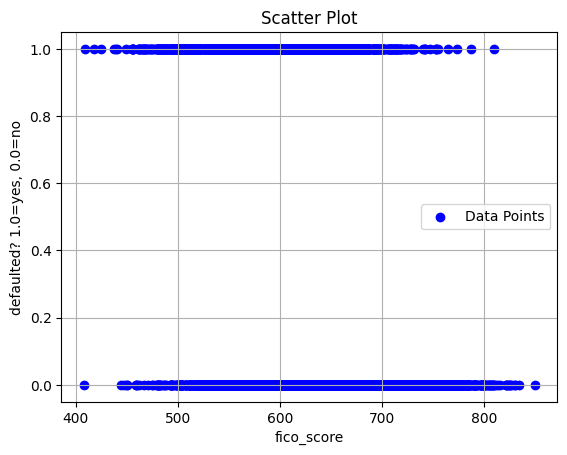

In [36]:
# Generate some sample data

x_values = df['fico_score']  # Independent variable (X-axis)
y_values = df['default']   # Dependent variable (Y-axis)

# Create a scatter plot
plt.scatter(x_values, y_values, color='b', marker='o', label='Data Points')
plt.title('Scatter Plot')
plt.xlabel('fico_score')
plt.ylabel('defaulted? 1.0=yes, 0.0=no')
plt.grid(True)
plt.legend()
plt.show()

In [35]:
df[ (df['fico_score'] >= 600) & (df['fico_score'] <= 600) ]

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
619,7648219,5,3275.017159,14488.745830,51889.82610,6,600,1
685,1040223,0,4951.340315,7569.230092,77858.65359,4,600,0
1025,7292536,1,2203.415655,3523.557054,46555.92120,5,600,0
1309,5257620,0,3604.078705,6562.685054,74606.40454,3,600,0
1316,2501479,0,2784.240833,4694.665576,51121.59387,3,600,0
1446,6526944,0,5266.389458,808.185886,80818.58862,4,600,0
1481,8674460,0,5472.179581,7620.656430,90381.26612,3,600,0
1882,7820525,0,4748.917715,3002.126730,76460.27558,6,600,0
1957,1815900,1,4220.434244,7419.839743,86011.37032,5,600,0
2003,3121727,0,3034.911659,5829.031425,79336.35104,5,600,0


In [ ]:
# NEXT STEPS: lookup quantization using MSE and MLE
#               will need to reach out to external help

In [12]:
# Quantizing a list of values to a specified number of discrete levels
def quantize_values(values, num_levels):
    """
    Quantizes a list of values to a specified number of discrete levels.
    
    Args:
        values (list): List of numerical values.
        num_levels (int): Number of discrete levels to quantize to.
    
    Returns:
        list: Quantized values.
    """
    min_value = min(values)
    max_value = max(values)
    step = (max_value - min_value) / (num_levels - 1)
    
    quantized_values = []
    for value in values:
        quantized_value = round((value - min_value) / step) * step + min_value
        quantized_values.append(quantized_value)
    
    return quantized_values

# Example usage
original_values = [2.3, 4.8, 6.1, 3.5, 5.2]
quantized_levels = 2
quantized_result = quantize_values(original_values, quantized_levels)

print(f"Original values: {original_values}")
print(f"Quantized values: {quantized_result}")


Original values: [2.3, 4.8, 6.1, 3.5, 5.2]
Quantized values: [2.3, 6.1, 6.1, 2.3, 6.1]
